### __Exploratory Data Analysis (EDA) Strategy for Audio Emotion Data__

**1. Data Collection and Initial Preparation:**
   - **Loading Data**: The process begins by loading audio files from a specified directory. Each audio file corresponds to an emotion category, with the data organized by directories named after the emotions.
   - **Labeling**: Each audio file is assigned a numerical label based on its corresponding emotion. This helps in organizing the data and preparing it for further analysis.

**2. Data Cleaning:**
   - **Noise Reduction**: To enhance the quality of the audio data, noise reduction techniques are applied. This step is crucial as it helps in removing unwanted noise from the recordings, making the subsequent analysis more accurate.
   - **Silence Trimming**: Silence at the beginning and end of the audio files is trimmed to ensure that the analysis focuses on the relevant parts of the audio. This is done to remove any non-informative segments.

**3. Exploratory Data Analysis (EDA):**
   - **Emotion Distribution**: A bar plot is created to visualize the distribution of audio samples across different emotions. This provides insight into the balance of the dataset and helps in identifying any biases or imbalances.
   - **Waveplots and Spectrograms**: 
     - **Waveplots**: For each emotion, an example audio file is selected, and its waveform is plotted. This visualization helps in understanding the general shape and structure of the audio signal.
     - **Spectrograms**: The spectrogram of each example audio is also plotted. Spectrograms visualize how the frequency content of the audio signal varies over time, providing insight into the audio's acoustic properties.
   - **Audio Length Statistics**: The duration of each audio file is calculated and analyzed. By grouping the data by emotion, summary statistics (such as mean, standard deviation, etc.) are computed to understand the distribution of audio lengths for each emotion.


Number of .wav files in sad folder: 168
Number of .wav files in happy folder: 276
Number of .wav files in angry folder: 204
Number of .wav files in calm folder: 184
Number of .wav files in surprised folder: 212


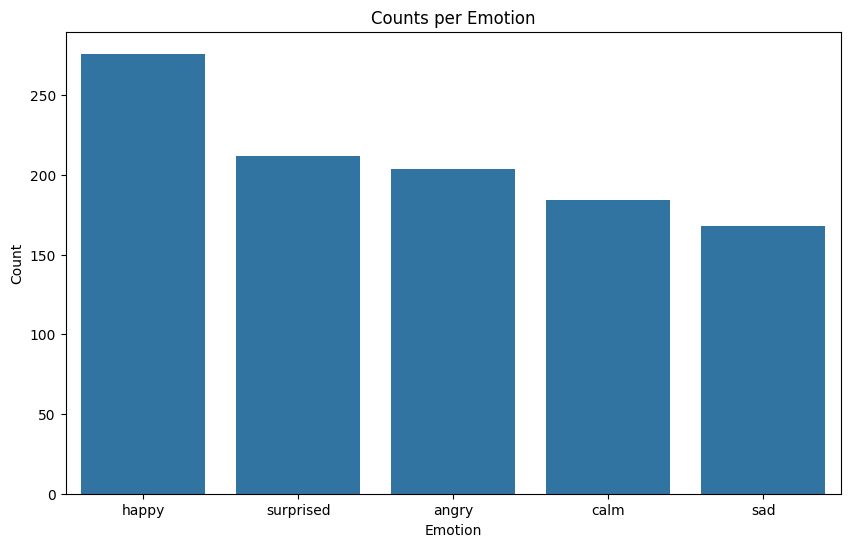

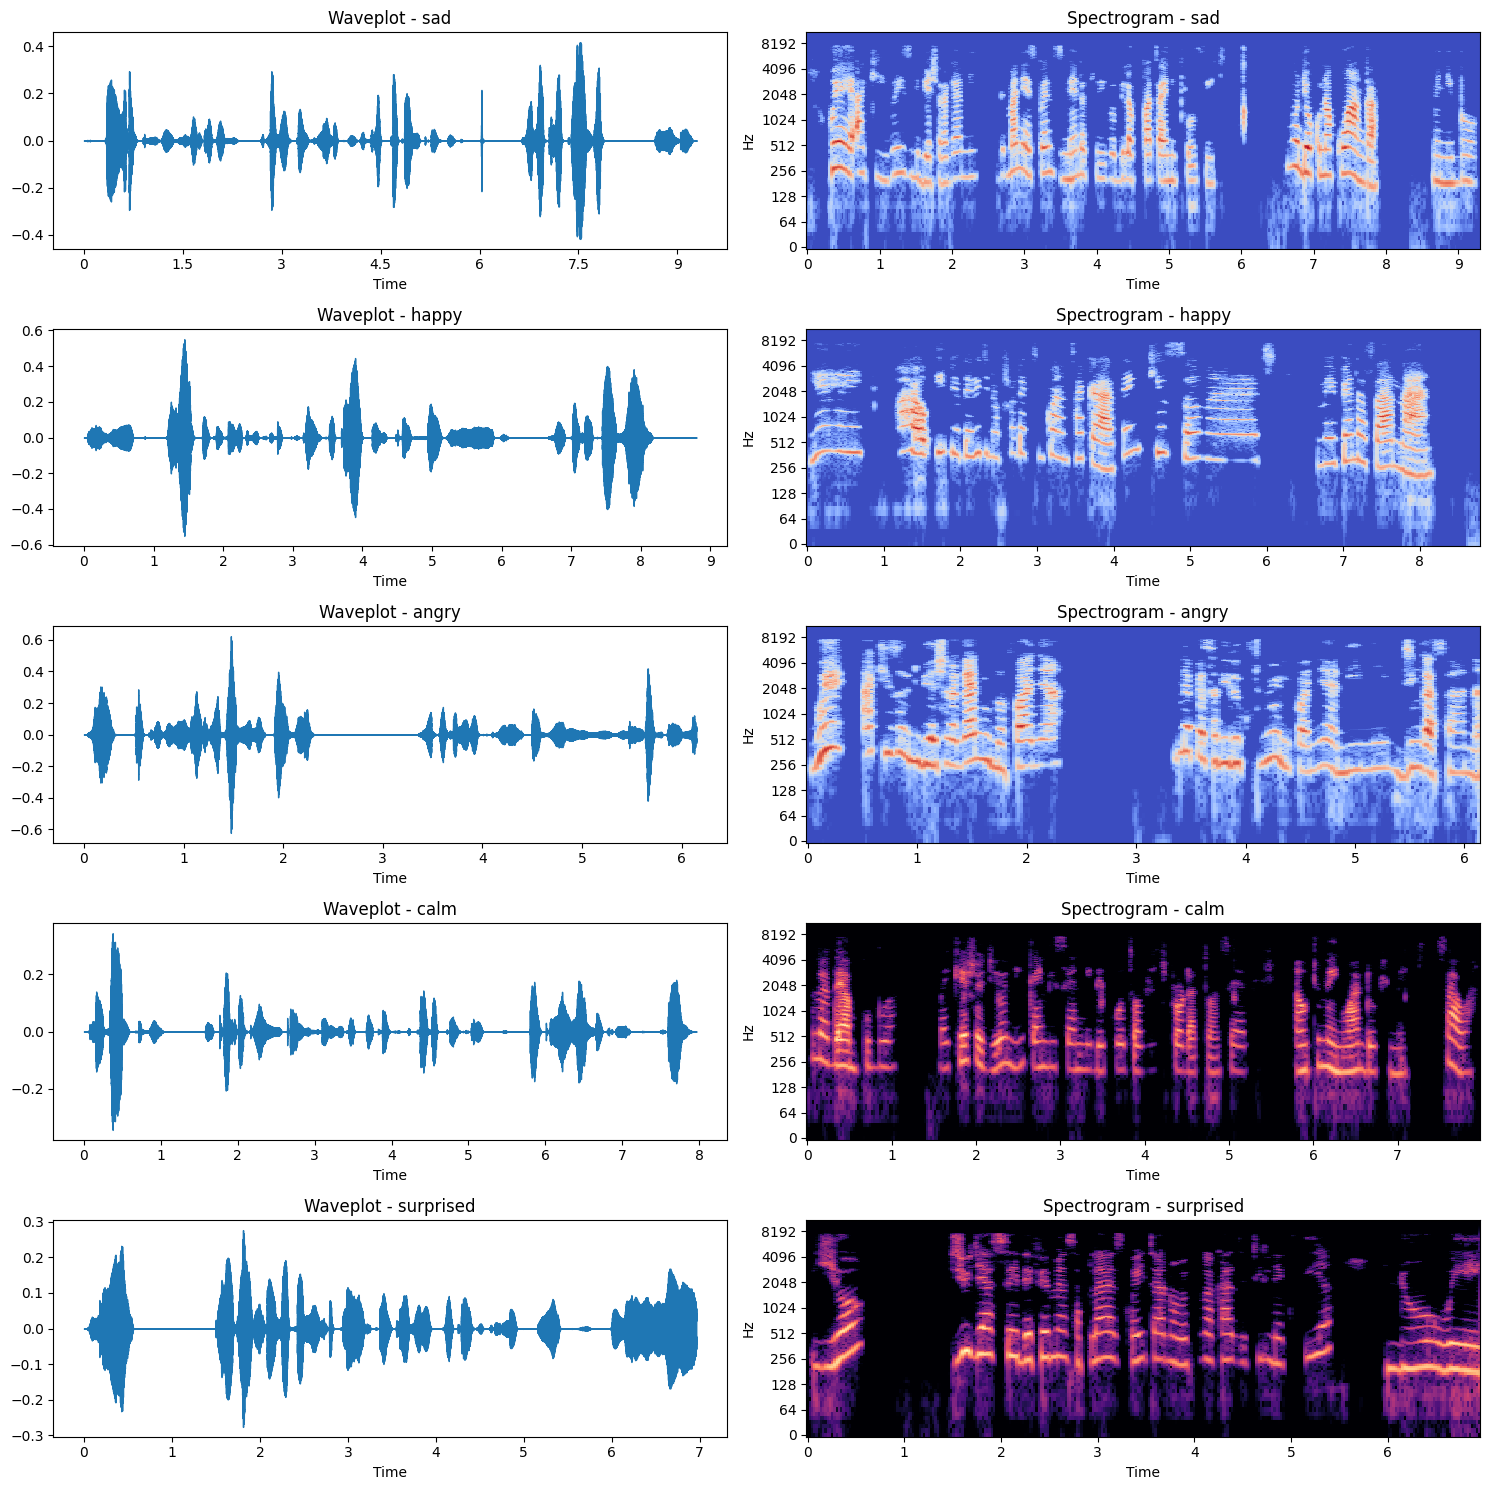

          Duration (seconds)                                          \
                       count      mean       std       min       25%   
Emotion                                                                
angry                  204.0  8.581964  2.059972  2.760998  7.915283   
calm                   184.0  6.377539  2.090704  3.599410  4.190839   
happy                  276.0  8.663881  1.996199  4.017052  7.972063   
sad                    168.0  6.881702  2.011440  3.558277  5.739909   
surprised              212.0  7.292247  2.106430  2.693515  6.362268   

                                          
                50%       75%        max  
Emotion                                   
angry      9.020952  9.844943  13.188844  
calm       6.520590  7.964444  11.772517  
happy      9.055782  9.968844  12.260136  
sad        6.292608  8.126984  10.968753  
surprised  7.569705  8.568163  11.454739  


In [8]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import noisereduce as nr  
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from audiomentations import Compose, PitchShift, TimeStretch, AddGaussianNoise


class DataLoader:
    def __init__(self, data_dir, emotions):
        self.data_dir = data_dir
        self.emotions = emotions
        self.X = []  # List to store audio data (as numpy arrays)
        self.y = []  # List to store corresponding labels

    def load_data(self):
        for i, emotion in enumerate(self.emotions):
            emotion_dir = os.path.join(self.data_dir, emotion)
            wav_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
            print(f"Number of .wav files in {emotion} folder: {len(wav_files)}")

            for filename in wav_files:
                filepath = os.path.join(emotion_dir, filename)
                audio, sample_rate = librosa.load(filepath)
                self.X.append(audio)
                self.y.append(i)  # Use emotion index as label

        self.y = np.array(self.y)  # Convert labels to numpy array

class DataCleaner:
    def __init__(self, X, sample_rate):
        self.X = X
        self.sample_rate = sample_rate

    def clean_data(self):
        cleaned_X = []
        for audio in self.X:
            # Noise Reduction
            cleaned_audio = nr.reduce_noise(y=audio, sr=self.sample_rate)

            # Trim Silence
            cleaned_audio, _ = librosa.effects.trim(cleaned_audio)

            cleaned_X.append(cleaned_audio)
        return cleaned_X

class EDA:
    def __init__(self, X, y, emotions):
        self.X = X
        self.y = y
        self.emotions = emotions

    def perform_eda(self):
        # Counts per Emotion
        counts = pd.Series(self.y).value_counts().reset_index()
        counts.columns = ['Emotion Index', 'Count']
        counts['Emotion'] = counts['Emotion Index'].map({i: emotion for i, emotion in enumerate(self.emotions)})
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Emotion', y='Count', data=counts)
        plt.title('Counts per Emotion')
        plt.show()

        # Waveplots and Spectrograms
        fig, axes = plt.subplots(nrows=len(self.emotions), ncols=2, figsize=(15, 15))
        for i, emotion in enumerate(self.emotions):
            # Find an example audio for this emotion
            example_idx = np.where(self.y == i)[0][0]
            example_audio = self.X[example_idx]

            # Waveplot
            librosa.display.waveshow(example_audio, sr=sample_rate, ax=axes[i, 0])
            axes[i, 0].set_title(f'Waveplot - {emotion}')

            # Spectrogram
            spectrogram = librosa.stft(example_audio)
            
            # Extract magnitude (amplitude) from the complex spectrogram
            magnitude_spectrogram = np.abs(spectrogram) 
            
            # Now convert to dB scale
            librosa.display.specshow(librosa.amplitude_to_db(magnitude_spectrogram),
                                     y_axis='log', x_axis='time', ax=axes[i, 1])
            axes[i, 1].set_title(f'Spectrogram - {emotion}')

        plt.tight_layout()
        plt.show()

         # Audio Length Statistics
        audio_lengths = [len(audio) / sample_rate for audio in self.X]  # in seconds

        # Ensure self.y is a 1D array of integers
        y_indices = self.y.ravel().astype(int)  # Flatten if necessary and convert to int

        # Now use y_indices to access emotions
        df = pd.DataFrame({'Emotion': [self.emotions[i] for i in y_indices], 
                           'Duration (seconds)': audio_lengths})
        
        print(df.groupby('Emotion').describe())

# Load the DataLoader
data_dir = "data"
emotions = ["sad", "happy", "angry", "calm", "surprised"]

loader = DataLoader(data_dir, emotions)
loader.load_data()

# Get the sample rate from one of the audio files
sample_rate = librosa.get_samplerate(os.path.join(data_dir, emotions[0], os.listdir(os.path.join(data_dir, emotions[0]))[0]))

# Create the DataCleaner instance
cleaner = DataCleaner(loader.X, sample_rate)
cleaned_X = cleaner.clean_data()

eda = EDA(cleaned_X, loader.y, emotions)
eda.perform_eda()

